In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk 
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('english')
import seaborn as sns

In [2]:
workshops = pd.read_csv("workshops.csv").drop("Unnamed: 0", axis=1)
timestamp = pd.to_datetime(workshops['Timestamp'])
workshops['Timestamp'] = timestamp
workshops.columns

Index(['Workshop_Type', 'Timestamp', 'email', 'gender', 'first name',
       'last name', 'raw_studies', 'academic standing', 'study',
       'R-workshop attendance', 'past attendance', 'first attendance',
       'python_attendance', 'race', 'ethnicity', 'feedback', 'no_punc',
       'polarity', 'listserv', 'how did you hear about us', 'code background'],
      dtype='object')

Text(0.5,0.98,'10 Most Positive Words and Their Counts; Most and Least Positive Words Used')

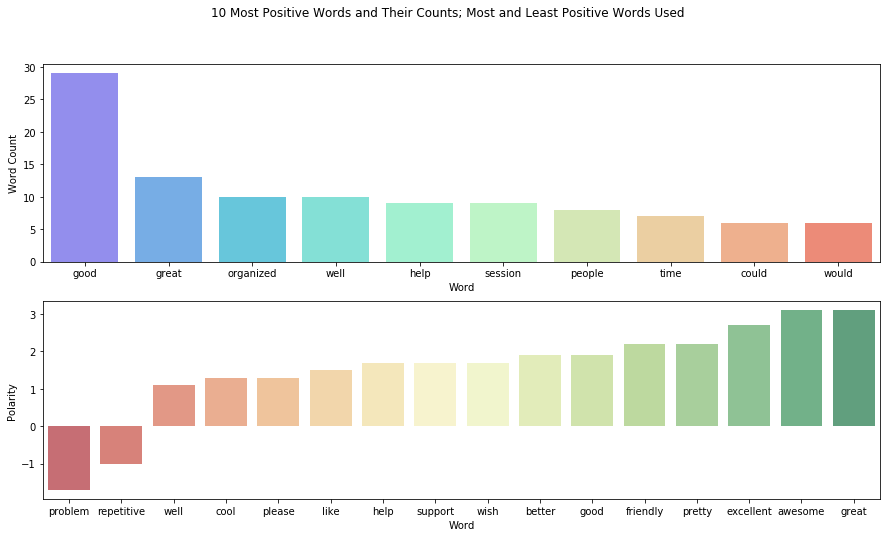

In [3]:
lexicon = pd.read_csv('vader_lexicon.txt',
                       sep='\t', 
                       header=None,
                       engine='python',
                       names=['token', 'polarity', 'sd', 'raw'])

sent = lexicon.drop({'sd','raw'},axis=1).set_index('token')

#### ---- 

polarity = workshops[["Timestamp", "no_punc", "polarity", "Workshop_Type"]].drop(workshops.index[1634:]).dropna()

words = [i for i in nltk.tokenize.word_tokenize(polarity['no_punc'].str.cat(sep=' ')) if i not in stop]
word_dist = nltk.FreqDist(words)

freq = pd.DataFrame.from_dict(data=dict(word_dist), orient='index', columns=["freq"])

polarity2 = freq.join(lexicon.set_index('token')).dropna()
p2graph = (polarity2[(polarity2["freq"] > 1)]
           .sort_values('polarity').iloc[0:2,:]
           .append(polarity2[(polarity2["freq"] > 1)]
                   .sort_values('polarity', ascending=False)
                   .iloc[:,:].sort_values("polarity")))

#### ----

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8))

sns.color_palette("husl", 8)
sns.barplot(x="index", y='freq', 
            data=freq.sort_values("freq", ascending=False).iloc[0:10,:].reset_index(),
            palette=sns.color_palette("rainbow", 10), 
            alpha=0.7, ax=ax1)

sns.barplot(x="index", y='polarity', 
            data=p2graph.reset_index(), 
            palette="RdYlGn", 
            ax=ax2, alpha=0.7)

ax1.set_ylabel("Word Count")
ax1.set_xlabel("Word")
ax2.set_xlabel("Word")
ax2.set_ylabel("Polarity")
f.suptitle("10 Most Positive Words and Their Counts; Most and Least Positive Words Used")

Text(0,0.5,'')

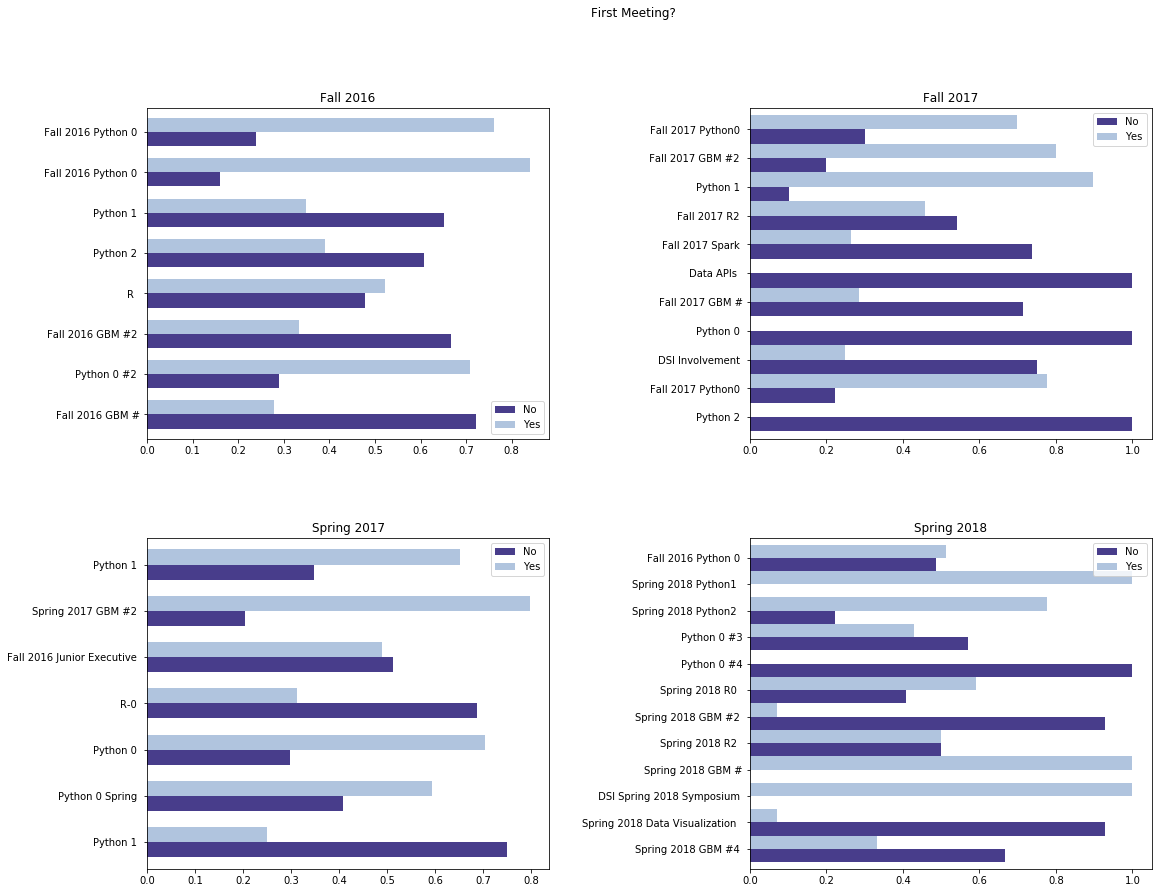

In [4]:
### proportion new, proportion not new 

atten = workshops[["Timestamp", "Workshop_Type", "past attendance", "first attendance"]].dropna(how='all')


atten["past"] = atten["past attendance"].map(dict(Yes=1, No=0))
atten["first"] = atten["first attendance"].map(dict(Yes=1, No=0))


atten1 = atten.set_index("Timestamp").loc['2016-07-01':'2017-01-01'].reset_index()
atten2 = atten.set_index("Timestamp").loc['2017-01-02':'2017-06-01'].reset_index()
atten3 = atten.set_index("Timestamp").loc['2017-06-02':'2018-01-01'].reset_index()
atten4 = atten.set_index("Timestamp").loc['2018-01-02':'2018-06-01'].reset_index()

lis = []
for i in [atten1, atten2, atten3, atten4]:
    lis.append(pd.Series(i.groupby("Workshop_Type").first().sort_values(
        "Timestamp").index).str.replace("Sign.*|Workshop|Copy of|Post.*|Board.*|SIGN IN|3.*", ""))

lis[3] = pd.Series(list(lis[3])[:8] + ['Python 0 #3', 'Python 0 #4'] + list(lis[3][8:])).str.replace("Workshop", "")
lis[2] = lis[2].str.replace("\(.*|Copy of|Workshop", "")

### ---

f, axes = plt.subplots(2, 2, figsize=(18,14))

f.suptitle("First Meeting?")

a1g = (atten1[~(atten1["Timestamp"]
                .dt.strftime('%Y-%m-%d') == ('2016-10-25'))]
                .resample("D", on="Timestamp").mean().dropna()
                .rename(columns={"past":"No", "first":"Yes"}).sort_index(ascending=False)
                .plot(kind='barh', title='Fall 2016', 
                      color=['darkslateblue', 'lightsteelblue'], 
                      width=.7,ax=axes[0,0])).set_yticklabels(list(lis[0])[::-1])

a2g = (atten2.resample("D", on="Timestamp").mean().dropna()
                .rename(columns={"past":"No", "first":"Yes"}).sort_index(ascending=False)
                .plot(kind='barh', title='Spring 2017',
                      color=['darkslateblue', 'lightsteelblue'], 
                      width=.65, ax=axes[1,0])).set_yticklabels(list(lis[1])[::-1])

a3g = (atten3.resample("D", on="Timestamp").mean().dropna()
                .rename(columns={"past":"No", "first":"Yes"}).sort_index(ascending=False)
                .plot(kind='barh', title='Fall 2017', color=['darkslateblue', 'lightsteelblue'],
                      width=1,ax=axes[0,1])).set_yticklabels(list(lis[2])[::-1])

a4g = (atten4.resample("D", on="Timestamp").mean().dropna()
                .rename(columns={"past":"No", "first":"Yes"}).sort_index(ascending=False)
                .plot(kind='barh', title='Spring 2018',color=['darkslateblue', 'lightsteelblue'],
                      width=1,ax=axes[1,1])).set_yticklabels(list(lis[3])[::-1])

plt.subplots_adjust(hspace=.3, wspace=0.5)
axes[0,0].set_ylabel("")
axes[0,1].set_ylabel("")
axes[1,0].set_ylabel("")
axes[1,1].set_ylabel("")

Text(0.5,0.98,"Proportion of Attendees' Academic Standing")

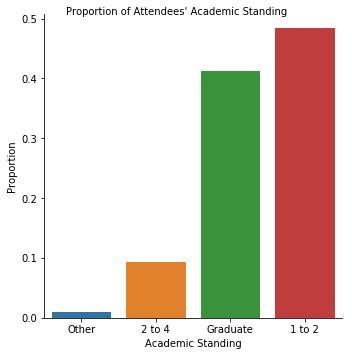

In [5]:
aca = workshops[["Timestamp", "Workshop_Type", 'first attendance', "academic standing"]].dropna(subset=['academic standing'])

acag = aca.groupby('academic standing').count().reset_index().sort_values('Timestamp')

acap = aca.groupby('academic standing').count().agg(lambda x: x/len(aca)).reset_index().sort_values('Timestamp')

g = sns.catplot(x='academic standing', y='Timestamp', kind='bar', data=acap)
g.set_axis_labels("Academic Standing", "Proportion")
fig = g.fig
fig.suptitle("Proportion of Attendees' Academic Standing", size=10)

In [8]:
totalno = acas[acas['first attendance'] == 'No']['first'].sum()
totalyes = acas[acas['first attendance'] == 'Yes']['first'].sum()

acas = aca.join(atten['first']).dropna(subset=['first attendance']).groupby(
    ['academic standing', 'first attendance']).count()[['first']].reset_index()

acano = acas[acas['first attendance'] == 'No'][['first']] / totalno
acayes = acas[acas['first attendance'] == 'Yes'][['first']] / totalyes

acasg = acas.join(acano.append(acayes).sort_index(), lsuffix='1').sort_values('first')


gr = sns.catplot(x='first attendance', y='first', hue='academic standing',kind='bar', 
            legend_out=True, data=acasg)
gr.set_axis_labels("First Attendance?", "Proportion of Yes/No")

NameError: name 'acas' is not defined

In [7]:
study = workshops[["Timestamp", "Workshop_Type", "study"]].dropna()
study

,Timestamp,Workshop_Type,study
142,2016-04-11 20:15:00,Spring 2016 Spark Post Workshop Survey (Respon...,"['comput', 'and', 'inform', 'sci', 'and', 'eng..."
143,2016-04-11 20:52:00,Spring 2016 Spark Post Workshop Survey (Respon...,"['comput', 'and', 'inform', 'sci', 'and', 'eng..."
144,2016-04-11 21:22:00,Spring 2016 Spark Post Workshop Survey (Respon...,"['comput', 'and', 'inform', 'sci', 'and', 'eng..."
145,2016-04-12 10:32:00,Spring 2016 Spark Post Workshop Survey (Respon...,"['comput', 'and', 'inform', 'sci', 'and', 'eng..."
146,2018-02-07 18:25:00,Spring 2018 Python2 Workshop Sign-In (2/7/2018...,"['biom', 'eng']"
147,2018-02-07 18:26:00,Spring 2018 Python2 Workshop Sign-In (2/7/2018...,"['comput', 'sci']"
148,2018-02-07 19:14:00,Spring 2018 Python2 Workshop Sign-In (2/7/2018...,"['comput', 'sci']"
149,2018-02-07 18:22:00,Spring 2018 Python2 Workshop Sign-In (2/7/2018...,"['comput', 'sci']"
150,2018-02-07 18:23:00,Spring 2018 Python2 Workshop Sign-In (2/7/2018...,"['comput', 'sci']"
151,2018-02-07 18:24:00,Spring 2018 Python2 Workshop Sign-In (2/7/2018...,['eng']
